In [1]:
from importlib import reload
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [2]:
from binance.client import Client
from binance import enums
api_key = "key"
api_secret = "secret"
client = Client(api_key, api_secret)

In [3]:
symbols = [
    'BTC/USDT',
    'XRP/USDT', 
    'ETH/USDT', 
    'ADA/USDT', 
    'XLM/USDT', 
    'XVG/USDT', 
    'LTC/USDT', 
    'IOTA/USDT', 
    'QTUM/USDT', 
    'NEO/USDT', 
    'DASH/USDT', 
    'ETC/USDT', 
    'LSK/USDT', 
    'XMR/USDT', 
    'OMG/USDT', 
    'STRAT/USDT', 
    'ZEC/USDT',
    'BCC/USDT'
]

In [24]:
import cryptoz
from cryptoz import stats, utils
from cryptoz.data import binance

ohlc = binance.chartdata(client, symbols, interval=enums.KLINE_INTERVAL_30MINUTE)

# klines

## pctchange

   count      mean       std       min       25%       50%       75%       max
0  846.0  0.002578  0.023195 -0.131803 -0.009341  0.002262  0.013358  0.196884


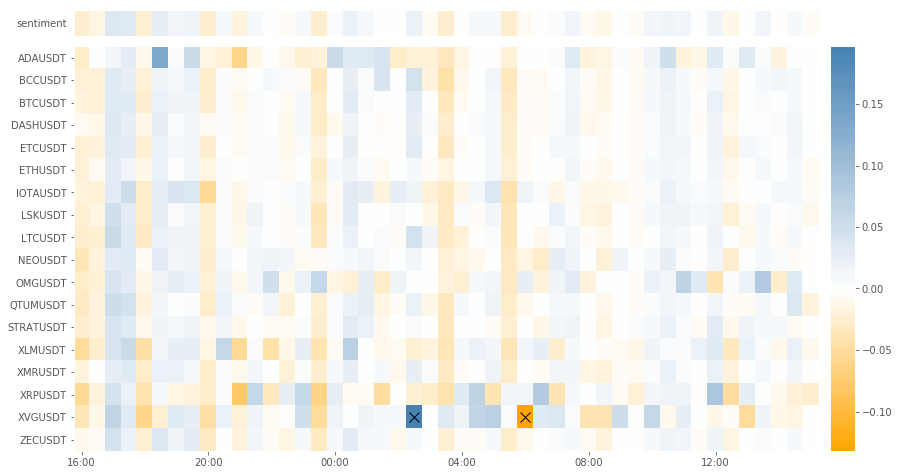

In [21]:
df = utils.to_df(ohlc, 'C').iloc[-48:]

cmap = cryptoz.plot.continuous_cmap(['orange', 'white', 'steelblue'])
norm = cryptoz.plot.midpoint_norm(0)
cryptoz.plot.evolution(df.pct_change().dropna(), cmap=cmap, norm=norm)

## hist

# drawdown

   count      mean      std       min       25%       50%       75%       max
0  864.0  0.310443  0.10124  0.055265  0.233772  0.334439  0.384552  0.563653


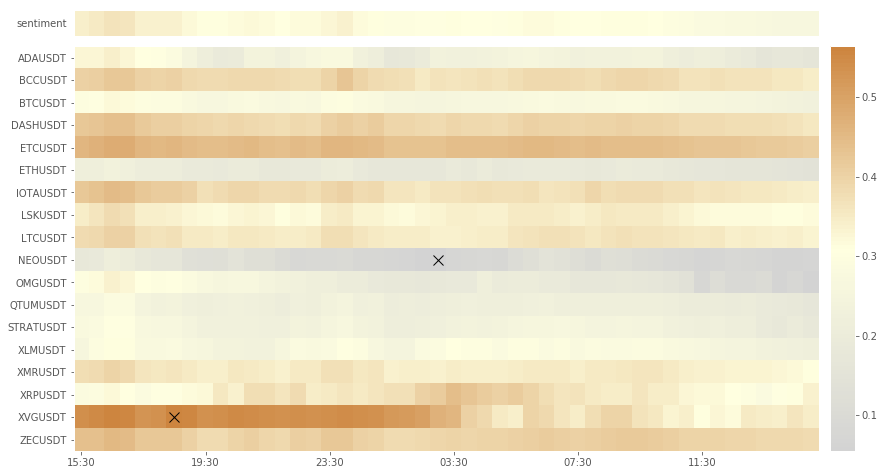

In [22]:
df = stats.dd.from_ohlc(ohlc).iloc[-48:]

cmap = cryptoz.plot.continuous_cmap(['lightgrey', 'lightyellow', 'peru'])
cryptoz.plot.evolution(df, cmap=cmap)

## current

In [7]:
stats.dd.now(ohlc)

OMGUSDT      0.045531
NEOUSDT      0.062374
ETHUSDT      0.145238
ADAUSDT      0.154623
QTUMUSDT     0.160863
STRATUSDT    0.173315
XLMUSDT      0.218606
BTCUSDT      0.229886
LSKUSDT      0.308005
XRPUSDT      0.310002
XMRUSDT      0.311405
LTCUSDT      0.332329
IOTAUSDT     0.339212
BCCUSDT      0.344931
XVGUSDT      0.346973
DASHUSDT     0.357253
ZECUSDT      0.379985
ETCUSDT      0.404165
dtype: float64

## max duration

## recovery

# performance

# correlation

## rolling

    count      mean       std       min      25%       50%       75%       max
0  6795.0  0.746358  0.361774 -0.862318  0.68892  0.904306  0.965606  0.998606


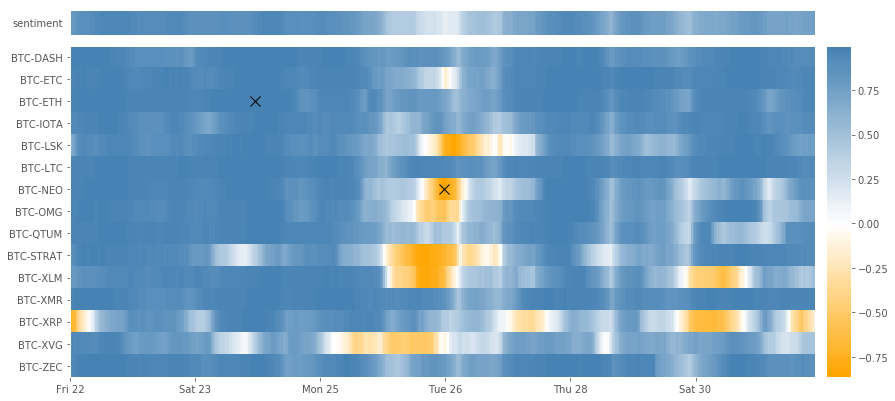

In [19]:
df = utils.to_df(ohlc, 'C')
df = stats.corr.rolling(df, window=48)
regex = re.compile(r'(BTCUSDT-.+)')
df = df[list(filter(regex.search, df.columns))]
df.columns = list(map(lambda x: re.sub(r'(USDT)', '', x), df.columns))

cmap = cryptoz.plot.continuous_cmap(['orange', 'white', 'steelblue'])
norm = cryptoz.plot.midpoint_norm(0)
cryptoz.plot.evolution(df.dropna(), cmap=cmap, norm=norm)

# depth

# score

## example: Bollinger Band

In [14]:
def rollmean(sr, window):
    return sr.rolling(window=window, min_periods=1).mean()

def rollstd(sr, window):
    return sr.rolling(window=window, min_periods=1).std()

def BollingerBand(sr, window, std_n):
    rollmean_sr = rollmean(sr, window)
    rollstd_sr = rollstd(sr, window)
    upper_band_sr = rollmean_sr + std_n * rollstd_sr
    lower_band_sr = rollmean_sr - std_n * rollstd_sr
    return upper_band_sr, lower_band_sr

def corridor(sr1, sr2):
    return sr1 - sr2

def normalize(sr):
    return (sr - sr.mean()) / sr.std()

### How wide is the BB?

    count      mean      std  min       25%       50%       75%  max
0  3438.0 -0.448615  1.50252 -2.0 -1.988039 -0.726216  0.838731  2.0


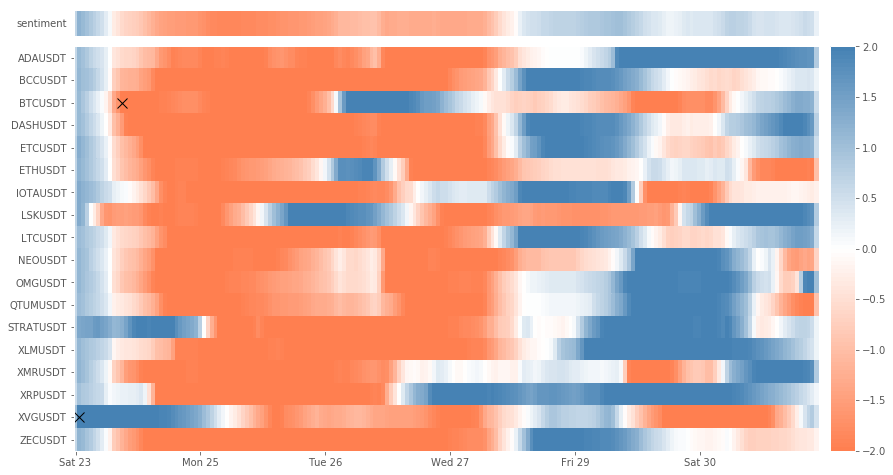

In [25]:
window = 120
std_n = 3

strategy = lambda ohlc_df: normalize(corridor(*BollingerBand(ohlc_df['C'], window, std_n)))
df1 = pd.DataFrame({pair: strategy(ohlc_df) for pair, ohlc_df in ohlc.items()})
score1_df = cryptoz.score.rolling_apply(df1, window=window, min_periods=window)
score1_df.dropna(inplace=True)

cmap = cryptoz.plot.continuous_cmap(['coral', 'white', 'steelblue'])
norm = cryptoz.plot.midpoint_norm(0)
cryptoz.plot.evolution(score1_df.resample('1h').sum(), cmap=cmap, norm=norm)

### Is the price above the MA?

    count      mean       std  min       25%       50%       75%  max
0  3438.0  0.304333  1.094008 -2.0 -0.549146  0.447729  1.233229  2.0


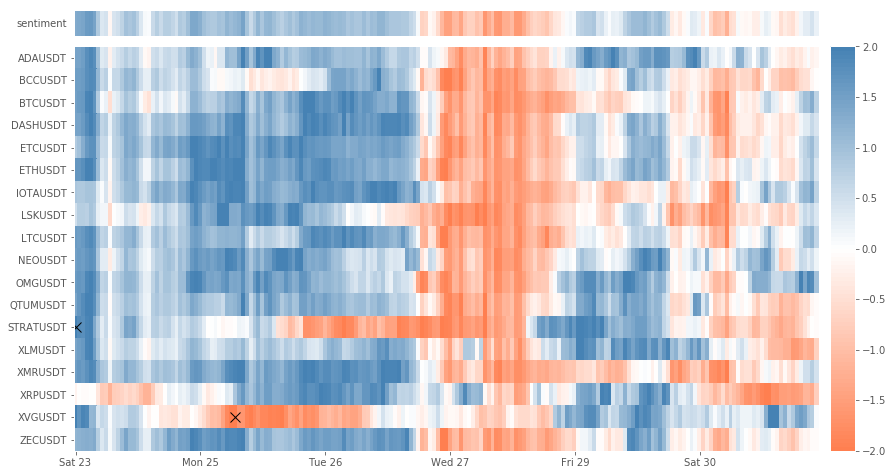

In [26]:
strategy = lambda ohlc_df: normalize(corridor(ohlc_df['C'], rollmean(ohlc_df['C'], window)))
df2 = pd.DataFrame({pair: strategy(ohlc_df) for pair, ohlc_df in ohlc.items()})
score2_df = cryptoz.score.rolling_apply(df2, window=window, min_periods=window)
score2_df.dropna(inplace=True)

cryptoz.plot.evolution(score2_df.resample('1h').sum(), cmap=cmap, norm=norm)

### When to buy/sell?

Rules
1. narrow corridor and price over MA -> trend up -> buy
2. wide corridor and price below MA -> oversold -> buy
3. narrow corridor and price below MA -> trend down -> sell
4. wide corridor and price above MA -> overbought -> sell

    count      mean       std  min       25%       50%       75%  max
0  3438.0 -0.261765  1.155095 -2.0 -1.312857 -0.408028  0.737216  2.0


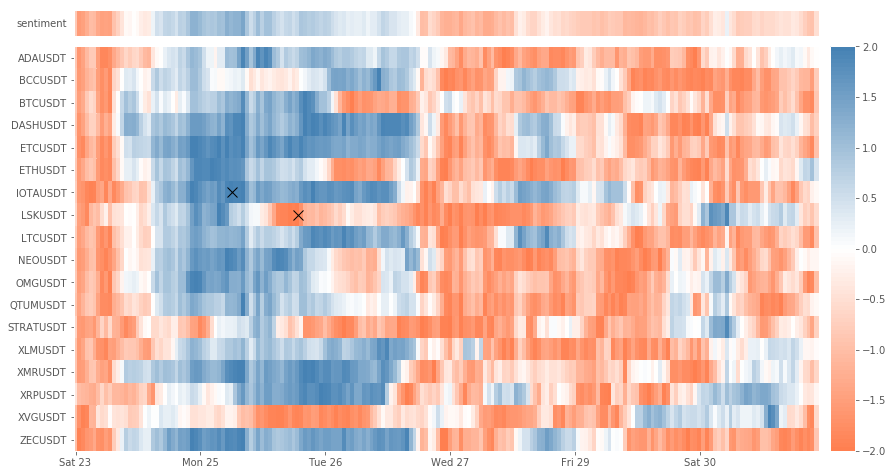

In [29]:
score_df = cryptoz.score.diff(score1_df, score2_df, axis=0) # axis 0: pair-local score
score_df.dropna(inplace=True)

cryptoz.plot.evolution(score_df.resample('1h').sum(), cmap=cmap, norm=norm)